In [1]:
DATA_DIR = "./data"

In [2]:
!mkdir -p $DATA_DIR
!test ! -d $DATA_DIR/train \
    && wget -O $DATA_DIR/train.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar \
    && tar -xf $DATA_DIR/train.tar -C $DATA_DIR \
    && rm -r $DATA_DIR/train.tar \
    && mv $DATA_DIR/train $DATA_DIR/streethazards_train
!test ! -d $DATA_DIR/test \
    && wget -O $DATA_DIR/test.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar \
    && tar -xf $DATA_DIR/test.tar -C $DATA_DIR \
    && rm -r $DATA_DIR/test.tar\
    && mv $DATA_DIR/test $DATA_DIR/streethazards_test

--2025-10-11 23:18:04--  https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9386226176 (8.7G) [application/x-tar]
Saving to: ‘./data/train.tar’

./data/train.tar    100%[===================>]   8.74G  87.1MB/s    in 66s     

2025-10-11 23:19:11 (135 MB/s) - ‘./data/train.tar’ saved [9386226176/9386226176]

--2025-10-11 23:19:32--  https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2150484992 (2.0G) [application/x-tar]
Saving to: ‘./data/test.tar’

./data/test.tar     100%[===================

In [3]:
!pip install -U segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 818.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [4]:
import numpy as np
import os
from enum import IntEnum
import torch
from torch import Tensor
import torch.nn as nn
import segmentation_models_pytorch as smp
from typing import Optional, Callable, Union, Tuple, Dict, List
import json
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.transforms import v2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

cuda


In [5]:
"""
Source: https://github.com/hendrycks/anomaly-seg/issues/15#issuecomment-890300278
"""
COLORS = np.array([
    [ 70,  70,  70],  # building     =   0,
    [190, 153, 153],  # fence        =   1, 
    [250, 170, 160],  # other        =   2,
    [220,  20,  60],  # pedestrian   =   3, 
    [153, 153, 153],  # pole         =   4,
    [157, 234,  50],  # road line    =   5, 
    [128,  64, 128],  # road         =   6,
    [244,  35, 232],  # sidewalk     =   7,
    [107, 142,  35],  # vegetation   =   8, 
    [  0,   0, 142],  # car          =   9,
    [102, 102, 156],  # wall         =  10, 
    [220, 220,   0],  # traffic sign =  11,
    [ 60, 250, 240],  # anomaly      =  12,
]) 


def visualize_annotation(annotation_img: np.ndarray | torch.Tensor, ax=None, title= None) -> None:
    """
    Visualize a segmentation annotation using a predefined color palette.

    Args:
        annotation_img (np.ndarray | torch.Tensor): 2D array with class indices.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, uses current axis.
    """
    if ax is None: ax = plt.gca()
    annotation_img = np.asarray(annotation_img)
    img_new = np.zeros((*annotation_img.shape, 3))

    for index, color in enumerate(COLORS):
        img_new[annotation_img == index] = color

    ax.imshow(img_new / 255.0)
    if title:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

def visualize_scene(image: np.ndarray | torch.Tensor, ax=None, title= None) -> None:
    """
    Visualize a raw RGB scene image.

    Args:
        image (np.ndarray | torch.Tensor): Image tensor or array in [C, H, W] or [H, W, C] format.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, uses current axis.
    """
    if ax is None: ax = plt.gca()
    image = np.asarray(image)
    ax.imshow(np.moveaxis(image, 0, -1))
    if title:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])


class StreetHazardsClasses(IntEnum):
    BUILDING        = 0
    FENCE           = 1
    OTHER           = 2
    PEDESTRIAN      = 3
    POLE            = 4
    ROAD_LINE       = 5
    ROAD            = 6
    SIDEWALK        = 7
    VEGETATION      = 8
    CAR             = 9
    WALL            = 10
    TRAFFIC_SIGN    = 11
    ANOMALY         = 12
    
#path to streethazards dataset
train_odgt_file = f"{DATA_DIR}/streethazards_train/train.odgt"
val_odgt_file = f"{DATA_DIR}/streethazards_train/validation.odgt"
test_odgt_file = f"{DATA_DIR}/streethazards_test/test.odgt"

COMPUTE_MEAN_STD = False

In [6]:
class StreetHazardsDataset(Dataset):
    """
    A custom PyTorch Dataset for the StreetHazards inliner dataset.

    This dataset reads image and segmentation label paths from a `.odgt` file,
    applies optional resizing and spatial transformations, and returns
    dictionary-style samples with normalized image tensors and label tensors.

    Args:
        odgt_file (str): Path to the `.odgt` file containing image and label metadata.
        image_resize (Tuple[int, int], optional): Target size to resize images and labels. 
        spatial_transforms (Callable, optional): Optional transformation function applied to both images and labels.
        mean_std (Tuple[List[float], List[float]], optional): Mean and standard deviation for image normalization.
        
    """
    def __init__(
        self,
        odgt_file: str,
        image_resize: Tuple[int, int] = (512, 896),
        spatial_transforms: Optional[Callable] = None,
        mean_std: Tuple[List[float], List[float]] = None
    ):

        self.spatial_transforms = spatial_transforms
        self.mean_std = mean_std
        self.image_resize = image_resize

        with open(odgt_file, "r") as f:
            odgt_data = json.load(f)
        

        self.paths = [
            {
                "image": os.path.join(Path(odgt_file).parent, data["fpath_img"]),
                "labels": os.path.join(Path(odgt_file).parent, data["fpath_segm"]),
            }
            for data in odgt_data 
        ]
    
    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:

        image = Image.open(self.paths[idx]["image"]).convert("RGB")
        labels = Image.open(self.paths[idx]["labels"])

        if self.image_resize:
            image = transforms.Resize(self.image_resize, transforms.InterpolationMode.BILINEAR)(image)
            labels = transforms.Resize(self.image_resize, transforms.InterpolationMode.NEAREST)(labels)
            
        if self.spatial_transforms:
            image, labels  = self.spatial_transforms(image, labels)         

        #to_tensor
        image = transforms.ToTensor()(image)
        labels = torch.as_tensor(transforms.functional.pil_to_tensor(labels), dtype=torch.int64) - 1
        
        labels = labels.squeeze(0)
        
        if self.mean_std:
            image = transforms.Normalize(mean = self.mean_std[0], std = self.mean_std[1])(image)

        return {'image' : image, 'labels' : labels}

In [7]:
def create_one_hot_prototypes_torch(num_known_classes: int, t_value: float = 3.0, device: str = 'cpu') -> torch.Tensor:
    """
    Generates one-hot prototypes as a PyTorch tensor for a given number of known classes.
    Each prototype is a vector where only the element corresponding
    to its class index has the 't_value', and all other elements are 0.

    Args:
        num_known_classes (int): The total number of known (in-distribution) classes.
                                 This also determines the dimensionality of each prototype vector.
        t_value (float): The non-zero value at the class's specific index in the prototype.
                         As specified in the paper, this is often 3.0.
        device (str): The device on which to create the tensor ('cpu' or 'cuda').

    Returns:
        torch.Tensor: A 2D PyTorch tensor where each row is a prototype vector.
                      The shape will be (num_known_classes, num_known_classes).
    """
    if not isinstance(num_known_classes, int) or num_known_classes <= 0:
        raise ValueError("num_known_classes must be a positive integer.")
    if not isinstance(t_value, (int, float)):
        raise ValueError("t_value must be a numeric type.")
    if device not in ['cpu', 'cuda']:
        raise ValueError("device must be 'cpu' or 'cuda'.")

    # Create a tensor of zeros
    prototypes = torch.zeros((num_known_classes, num_known_classes), dtype=torch.float32, device=device)

    # Fill the diagonal with t_value to create one-hot prototypes
    for i in range(num_known_classes):
        prototypes[i, i] = t_value
        
    # An even more concise way using torch.eye (Identity matrix)
    # prototypes = torch.eye(num_known_classes, dtype=torch.float32, device=device) * t_value

    return prototypes

Prototype  = create_one_hot_prototypes_torch(13)

In [8]:

class DMLNetFeatureExtractor(torch.nn.Module):
    def __init__(self, encoder_name, encoder_weights, num_feature_channels, activation):
        super().__init__()
        

        self.model = smp.DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            classes=num_feature_channels, # This sets the output channels of the segmentation_head if kept
            activation=activation # Usually 'None' for the main head, but for features it might not matter directly
        )
        

        # Option 2 is safer and more robust.
        # First, we disable the original segmentation head as you did.
        self.original_segmentation_head = self.model.segmentation_head # Store it if needed
        self.model.segmentation_head = torch.nn.Identity() # Remove the final head

        # --- CORRECTION START ---
        # To get the decoder's actual output channels, we need a dummy forward pass
        # through just the encoder and decoder.
        
        # Temporarily detach the module to make a dummy pass if needed,
        # but in __init__, we can usually just do a conceptual forward.
        # However, to be absolutely safe and get the runtime channel count:
        
        # Create a dummy input to trace the decoder output channels
        # Assuming typical RGB input (3 channels) and arbitrary spatial dimensions
        dummy_input = torch.randn(2, 3, 256, 256) 
        
        # Pass through encoder
        encoder_features_dummy = self.model.encoder(dummy_input)
        
        # Pass through decoder to get its output channels
        decoder_output_dummy = self.model.decoder(encoder_features_dummy)
        
        # Extract the channel dimension from the dummy output
        decoder_actual_out_channels = decoder_output_dummy.shape[1]
        # --- CORRECTION END ---

        # Add a 1x1 convolution to project the decoder's output to the desired num_feature_channels.
        self.feature_projection = torch.nn.Conv2d(
            in_channels=decoder_actual_out_channels,
            out_channels=num_feature_channels,
            kernel_size=1,
            stride=1,
            padding=0
        )
        
    def forward(self, x):
        input_spatial_size = x.shape[2:]
        # The encoder outputs a list of feature maps at different resolutions
        encoder_features = self.model.encoder(x)
        
        # The decoder takes these features and produces a high-resolution feature map.
        # This output will typically have the same spatial dimensions as the input 'x'
        # (due to DeepLabV3+ decoder's upsampling) but with its default channel count.
        decoder_output = self.model.decoder(encoder_features)
        
        # Project the decoder's output to the desired number of feature channels
        projected_features = self.feature_projection(decoder_output)

        final_features = torch.nn.functional.interpolate(
            projected_features, 
            size=input_spatial_size, 
            mode='bilinear', 
            align_corners=False # Set to True for pixel alignment if needed, but False is common
        )
        
        # These `final_features` are your f(X; θf)i,j with num_feature_channels.
        return final_features

In [9]:
class DiscriminativeCrossEntropyLoss(nn.Module):
    def __init__(self, prototypes: torch.Tensor,lambda_weight):
        super().__init__()
       
        self.prototypes = prototypes.to(device)
        self.lambda_weight = lambda_weight

    def forward(self, pixel_features: torch.Tensor, target_labels: torch.Tensor):
        # pixel_features: (B, D, H, W)
        # target_labels: (B, H, W)

        # Reshape pixel_features for easier broadcasting with prototypes
        # (B, D, H, W) -> (B, H, W, D)
        pixel_features_reshaped = pixel_features.permute(0, 2, 3, 1) # (B, H, W, D)

        # Expand target_labels to match the feature dimension for indexing prototypes
        # (B, H, W) -> (B, H, W, D)
        prototypes_target = self.prototypes[target_labels] # This should now be (B, H, W, D)

        # --- Numerator (Attractive Force) ---
        # ||f(X; θf)i,j – mY i,j ||²
        # (B, H, W, D) - (B, H, W, D) -> (B, H, W, D)
        difference_numerator = pixel_features_reshaped - prototypes_target
        # (B, H, W, D) -> (B, H, W)
        squared_diff_numerator = torch.sum(difference_numerator.pow(2), dim=-1)
        exp_squared_diff_numerator = torch.exp(-squared_diff_numerator)

        # --- Denominator (Repulsive Force) ---
        # Σk=1 to N ( exp(-||f(X; θf)i,j – mk ||²) )
        # To compute this, we need to calculate the squared difference for ALL prototypes
        # and then sum their exponentials.

        # Expand pixel_features to compare with all prototypes: (B, H, W, 1, D)
        pixel_features_expanded = pixel_features_reshaped.unsqueeze(-2) # (B, H, W, 1, D)

        # Expand prototypes to compare with all pixels: (1, 1, 1, N, D)
        # self.prototypes has shape (N, D)
        prototypes_expanded = self.prototypes.unsqueeze(0).unsqueeze(0).unsqueeze(0) # (1, 1, 1, N, D)

        # Calculate difference between each pixel feature and ALL prototypes
        # (B, H, W, 1, D) - (1, 1, 1, N, D) -> (B, H, W, N, D)
        all_prototypes_differences = pixel_features_expanded - prototypes_expanded

        # Square and sum across the feature dimension (D)
        # (B, H, W, N, D) -> (B, H, W, N)
        squared_diff_all_prototypes = torch.sum(all_prototypes_differences.pow(2), dim=-1)

        # Exponentiate
        # (B, H, W, N)
        exp_squared_diff_all_prototypes = torch.exp(-squared_diff_all_prototypes)

        # Sum across the prototype dimension (N) to get the denominator
        # (B, H, W, N) -> (B, H, W)
        denominator = torch.sum(exp_squared_diff_all_prototypes, dim=-1)

        # --- Calculate Pt(Xi,j) (Equation 2) ---
        # (B, H, W) / (B, H, W) -> (B, H, W)
        pt_values = exp_squared_diff_numerator / (denominator + 1e-8) # Add small epsilon for stability

        # --- Calculate LDCE (Equation 3) ---
        # LDCE = -log(pt_values) for target classes
        # This requires masking based on target_labels or using the pt_values directly
        # The equation shows sum over i,j of -log(numerator/denominator) where numerator corresponds to Y_i,j

        # Assuming Y_i,j is 1 for the target class at that pixel and 0 otherwise.
        # This is essentially -log(Pt(Xi,j)) for the correct class, summed over all pixels.
        ldce_loss = -torch.log(pt_values + 1e-8) # Add small epsilon for stability
        ldce_loss = torch.sum(ldce_loss) # Or torch.sum() depending on how you want to aggregate

        Lvl_loss = torch.sum(difference_numerator.pow(2))
        
        
        return ldce_loss + self.lambda_weight * Lvl_loss
       

In [10]:
shape_resize = (512, 896)

if COMPUTE_MEAN_STD:
    mean_streethazards, std_streethazards = compute_mean_std_channels(StreetHazardsDataset(odgt_file= train_odgt_file,
                                                                                           image_resize = shape_resize,
                                                                                           spatial_transforms=None,
                                                                                           mean_std=None))
else:
    mean_streethazards, std_streethazards = [0.3302, 0.3459, 0.373], [0.1595, 0.1577, 0.1712]

spatial_transforms = transforms.v2.Compose([
    transforms.v2.RandomHorizontalFlip(),
])

train_dataset = StreetHazardsDataset(
    odgt_file= train_odgt_file,
    image_resize = shape_resize,
    spatial_transforms=spatial_transforms,
    mean_std=(mean_streethazards, std_streethazards)
)

val_dataset = StreetHazardsDataset(
    odgt_file= val_odgt_file,
    image_resize = shape_resize,
    spatial_transforms=None,
    mean_std=(mean_streethazards, std_streethazards)
)

test_dataset = StreetHazardsDataset(
    odgt_file= test_odgt_file,
    image_resize = shape_resize,
    spatial_transforms=None,
    mean_std=(mean_streethazards, std_streethazards)
)

train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_dl = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_dl = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

In [11]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Esempio di utilizzo:
encoder_name = "resnet18"
encoder_weights = "imagenet"
num_known_classes = 13 # Numero di classi per cui i prototipi sono one-hot
t_value = 3.0
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Inizializza il feature extractor
feature_extractor = DMLNetFeatureExtractor(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    num_feature_channels=num_known_classes,
    activation=None
).to(device)
model_optimizer = torch.optim.Adam(feature_extractor.parameters(), lr=0.001)

def train(num_epochs,model,train_loader,lambda_weight) -> None:
        
        for epoch in tqdm(range(num_epochs), desc="Epoch"):
            
            model.train()

            losses = []

            for batch in train_loader: 

                    
                imgs = batch['image'].to(device)
                labels = batch['labels'].to(device)
                
                logits = model(imgs)
                
                lossClass = DiscriminativeCrossEntropyLoss(Prototype,lambda_weight)

                
                loss = lossClass(logits,labels)
                            
                losses.append(loss.item())
                
                model_optimizer.zero_grad()
                loss.backward()
                model_optimizer.step()
            
                del loss
                

            l = sum(losses) / len(losses)

            print(f"Epoch {epoch + 1}", end = ' ')

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [12]:
train(100,feature_extractor,train_dl,0.1)

Epoch:   1%|          | 1/100 [04:36<7:36:35, 276.73s/it]

Epoch 1 

Epoch:   2%|▏         | 2/100 [09:12<7:30:48, 276.00s/it]

Epoch 2 

Epoch:   3%|▎         | 3/100 [13:47<7:25:49, 275.77s/it]

Epoch 3 

Epoch:   4%|▍         | 4/100 [18:23<7:21:04, 275.67s/it]

Epoch 4 

Epoch:   5%|▌         | 5/100 [22:58<7:16:19, 275.57s/it]

Epoch 5 

Epoch:   6%|▌         | 6/100 [27:34<7:11:44, 275.58s/it]

Epoch 6 

Epoch:   7%|▋         | 7/100 [32:10<7:07:15, 275.65s/it]

Epoch 7 

Epoch:   8%|▊         | 8/100 [36:45<7:02:36, 275.61s/it]

Epoch 8 

Epoch:   9%|▉         | 9/100 [41:21<6:58:01, 275.62s/it]

Epoch 9 

Epoch:  10%|█         | 10/100 [45:56<6:53:23, 275.59s/it]

Epoch 10 

Epoch:  11%|█         | 11/100 [50:32<6:48:48, 275.60s/it]

Epoch 11 

Epoch:  12%|█▏        | 12/100 [55:07<6:44:13, 275.60s/it]

Epoch 12 

Epoch:  13%|█▎        | 13/100 [59:43<6:39:35, 275.58s/it]

Epoch 13 

Epoch:  14%|█▍        | 14/100 [1:04:18<6:34:57, 275.56s/it]

Epoch 14 

Epoch:  15%|█▌        | 15/100 [1:08:54<6:30:18, 275.52s/it]

Epoch 15 

Epoch:  16%|█▌        | 16/100 [1:13:30<6:25:45, 275.55s/it]

Epoch 16 

Epoch:  17%|█▋        | 17/100 [1:18:05<6:21:06, 275.49s/it]

Epoch 17 

Epoch:  18%|█▊        | 18/100 [1:22:40<6:16:31, 275.51s/it]

Epoch 18 

Epoch:  19%|█▉        | 19/100 [1:27:16<6:11:56, 275.51s/it]

Epoch 19 

Epoch:  20%|██        | 20/100 [1:31:51<6:07:19, 275.50s/it]

Epoch 20 

Epoch:  21%|██        | 21/100 [1:36:27<6:02:37, 275.42s/it]

Epoch 21 

Epoch:  22%|██▏       | 22/100 [1:41:02<5:57:59, 275.37s/it]

Epoch 22 

Epoch:  23%|██▎       | 23/100 [1:45:37<5:53:21, 275.35s/it]

Epoch 23 

Epoch:  24%|██▍       | 24/100 [1:50:13<5:48:48, 275.38s/it]

Epoch 24 

Epoch:  25%|██▌       | 25/100 [1:54:48<5:44:12, 275.37s/it]

Epoch 25 

Epoch:  26%|██▌       | 26/100 [1:59:23<5:39:37, 275.37s/it]

Epoch 26 

Epoch:  27%|██▋       | 27/100 [2:03:59<5:35:03, 275.38s/it]

Epoch 27 

Epoch:  28%|██▊       | 28/100 [2:08:34<5:30:25, 275.35s/it]

Epoch 28 

Epoch:  29%|██▉       | 29/100 [2:13:09<5:25:49, 275.35s/it]

Epoch 29 

Epoch:  30%|███       | 30/100 [2:17:45<5:21:13, 275.33s/it]

Epoch 30 

Epoch:  31%|███       | 31/100 [2:22:20<5:16:35, 275.29s/it]

Epoch 31 

Epoch:  32%|███▏      | 32/100 [2:26:55<5:11:58, 275.28s/it]

Epoch 32 

Epoch:  33%|███▎      | 33/100 [2:31:31<5:07:25, 275.31s/it]

Epoch 33 

Epoch:  34%|███▍      | 34/100 [2:36:06<5:02:50, 275.31s/it]

Epoch 34 

Epoch:  35%|███▌      | 35/100 [2:40:41<4:58:14, 275.30s/it]

Epoch 35 

Epoch:  36%|███▌      | 36/100 [2:45:17<4:53:41, 275.34s/it]

Epoch 36 

Epoch:  37%|███▋      | 37/100 [2:49:52<4:49:08, 275.38s/it]

Epoch 37 

Epoch:  38%|███▊      | 38/100 [2:54:27<4:44:33, 275.39s/it]

Epoch 38 

Epoch:  39%|███▉      | 39/100 [2:59:03<4:39:56, 275.36s/it]

Epoch 39 

Epoch:  40%|████      | 40/100 [3:03:38<4:35:16, 275.28s/it]

Epoch 40 

Epoch:  41%|████      | 41/100 [3:08:13<4:30:38, 275.23s/it]

Epoch 41 

Epoch:  42%|████▏     | 42/100 [3:12:48<4:26:05, 275.27s/it]

Epoch 42 

Epoch:  43%|████▎     | 43/100 [3:17:24<4:21:30, 275.28s/it]

Epoch 43 

Epoch:  44%|████▍     | 44/100 [3:21:59<4:16:54, 275.26s/it]

Epoch 44 

Epoch:  45%|████▌     | 45/100 [3:26:34<4:12:22, 275.32s/it]

Epoch 45 

Epoch:  46%|████▌     | 46/100 [3:31:10<4:07:47, 275.32s/it]

Epoch 46 

Epoch:  47%|████▋     | 47/100 [3:35:45<4:03:11, 275.32s/it]

Epoch 47 

Epoch:  48%|████▊     | 48/100 [3:40:20<3:58:39, 275.37s/it]

Epoch 48 

Epoch:  49%|████▉     | 49/100 [3:44:56<3:54:03, 275.36s/it]

Epoch 49 

Epoch:  50%|█████     | 50/100 [3:49:31<3:49:31, 275.42s/it]

Epoch 50 

Epoch:  51%|█████     | 51/100 [3:54:07<3:44:54, 275.39s/it]

Epoch 51 

Epoch:  52%|█████▏    | 52/100 [3:58:42<3:40:17, 275.36s/it]

Epoch 52 

Epoch:  53%|█████▎    | 53/100 [4:03:17<3:35:40, 275.34s/it]

Epoch 53 

Epoch:  54%|█████▍    | 54/100 [4:07:53<3:31:07, 275.38s/it]

Epoch 54 

Epoch:  55%|█████▌    | 55/100 [4:12:28<3:26:30, 275.34s/it]

Epoch 55 

Epoch:  56%|█████▌    | 56/100 [4:17:03<3:21:57, 275.39s/it]

Epoch 56 

Epoch:  57%|█████▋    | 57/100 [4:21:39<3:17:23, 275.42s/it]

Epoch 57 

Epoch:  58%|█████▊    | 58/100 [4:26:15<3:12:51, 275.50s/it]

Epoch 58 

Epoch:  59%|█████▉    | 59/100 [4:30:50<3:08:15, 275.51s/it]

Epoch 59 

Epoch:  60%|██████    | 60/100 [4:35:26<3:03:41, 275.53s/it]

Epoch 60 

Epoch:  61%|██████    | 61/100 [4:40:01<2:59:06, 275.56s/it]

Epoch 61 

Epoch:  62%|██████▏   | 62/100 [4:44:37<2:54:31, 275.57s/it]

Epoch 62 

Epoch:  63%|██████▎   | 63/100 [4:49:13<2:49:56, 275.57s/it]

Epoch 63 

Epoch:  64%|██████▍   | 64/100 [4:53:48<2:45:21, 275.59s/it]

Epoch 64 

Epoch:  65%|██████▌   | 65/100 [4:58:24<2:40:46, 275.60s/it]

Epoch 65 

Epoch:  66%|██████▌   | 66/100 [5:03:00<2:36:11, 275.64s/it]

Epoch 66 

Epoch:  67%|██████▋   | 67/100 [5:07:35<2:31:36, 275.64s/it]

Epoch 67 

Epoch:  68%|██████▊   | 68/100 [5:12:11<2:26:59, 275.61s/it]

Epoch 68 

Epoch:  69%|██████▉   | 69/100 [5:16:46<2:22:23, 275.59s/it]

Epoch 69 

Epoch:  70%|███████   | 70/100 [5:21:22<2:17:47, 275.59s/it]

Epoch 70 

Epoch:  71%|███████   | 71/100 [5:25:57<2:13:09, 275.50s/it]

Epoch 71 

Epoch:  72%|███████▏  | 72/100 [5:30:32<2:08:32, 275.44s/it]

Epoch 72 

Epoch:  73%|███████▎  | 73/100 [5:35:08<2:03:56, 275.41s/it]

Epoch 73 

Epoch:  74%|███████▍  | 74/100 [5:39:43<1:59:20, 275.39s/it]

Epoch 74 

Epoch:  75%|███████▌  | 75/100 [5:44:19<1:54:45, 275.40s/it]

Epoch 75 

Epoch:  76%|███████▌  | 76/100 [5:48:54<1:50:08, 275.37s/it]

Epoch 76 

Epoch:  77%|███████▋  | 77/100 [5:53:29<1:45:33, 275.38s/it]

Epoch 77 

Epoch:  78%|███████▊  | 78/100 [5:58:05<1:40:58, 275.38s/it]

Epoch 78 

Epoch:  79%|███████▉  | 79/100 [6:02:40<1:36:23, 275.41s/it]

Epoch 79 

Epoch:  80%|████████  | 80/100 [6:07:16<1:31:49, 275.45s/it]

Epoch 80 

Epoch:  81%|████████  | 81/100 [6:11:51<1:27:14, 275.49s/it]

Epoch 81 

Epoch:  82%|████████▏ | 82/100 [6:16:27<1:22:39, 275.51s/it]

Epoch 82 

Epoch:  83%|████████▎ | 83/100 [6:21:02<1:18:03, 275.50s/it]

Epoch 83 

Epoch:  84%|████████▍ | 84/100 [6:25:38<1:13:27, 275.49s/it]

Epoch 84 

Epoch:  85%|████████▌ | 85/100 [6:30:13<1:08:51, 275.44s/it]

Epoch 85 

Epoch:  86%|████████▌ | 86/100 [6:34:49<1:04:16, 275.46s/it]

Epoch 86 

Epoch:  87%|████████▋ | 87/100 [6:39:24<59:41, 275.51s/it]  

Epoch 87 

Epoch:  88%|████████▊ | 88/100 [6:44:00<55:06, 275.51s/it]

Epoch 88 

Epoch:  89%|████████▉ | 89/100 [6:48:35<50:30, 275.54s/it]

Epoch 89 

Epoch:  90%|█████████ | 90/100 [6:53:11<45:55, 275.58s/it]

Epoch 90 

Epoch:  91%|█████████ | 91/100 [6:57:46<41:19, 275.55s/it]

Epoch 91 

Epoch:  92%|█████████▏| 92/100 [7:02:22<36:44, 275.57s/it]

Epoch 92 

Epoch:  93%|█████████▎| 93/100 [7:06:58<32:09, 275.60s/it]

Epoch 93 

Epoch:  94%|█████████▍| 94/100 [7:11:33<27:33, 275.61s/it]

Epoch 94 

Epoch:  95%|█████████▌| 95/100 [7:16:09<22:57, 275.58s/it]

Epoch 95 

Epoch:  96%|█████████▌| 96/100 [7:20:44<18:22, 275.57s/it]

Epoch 96 

Epoch:  97%|█████████▋| 97/100 [7:25:20<13:46, 275.53s/it]

Epoch 97 

Epoch:  98%|█████████▊| 98/100 [7:29:55<09:11, 275.53s/it]

Epoch 98 

Epoch:  99%|█████████▉| 99/100 [7:34:31<04:35, 275.50s/it]

Epoch 99 

Epoch: 100%|██████████| 100/100 [7:39:06<00:00, 275.47s/it]

Epoch 100 

In [13]:
torch.save(feature_extractor, "model_weights100E.pth")

In [14]:
#loaded_model = torch.load("/kaggle/input/dml/pytorch/default/2/weights_50E.pth",weights_only=False)
#loaded_model.eval()
#feature_extractor = loaded_model

In [15]:
def get_probability(logits):
    # pixel_features: (B, D, H, W)
    # target_labels: (B, H, W)

    # Reshape pixel_features for easier broadcasting with prototypes
    # (B, D, H, W) -> (B, H, W, D)
    pixel_features_reshaped = logits.permute(0, 2, 3, 1) # (B, H, W, D)

    probability = torch.clone(pixel_features_reshaped)
    for t in range(13):
        # Expand target_labels to match the feature dimension for indexing prototypes
        # (B, H, W) -> (B, H, W, D)
        prototypes_t = Prototype[t].to(device) # This should now be (B, H, W, D)
    
        # --- Numerator (Attractive Force) ---
        # ||f(X; θf)i,j – mY i,j ||²
        # (B, H, W, D) - (B, H, W, D) -> (B, H, W, D)
        difference_numerator = pixel_features_reshaped - prototypes_t
        # (B, H, W, D) -> (B, H, W)
        squared_diff_numerator = torch.sum(difference_numerator.pow(2), dim=-1)
        exp_squared_diff_numerator = torch.exp(-squared_diff_numerator)
    
        # --- Denominator (Repulsive Force) ---
        # Σk=1 to N ( exp(-||f(X; θf)i,j – mk ||²) )
        # To compute this, we need to calculate the squared difference for ALL prototypes
        # and then sum their exponentials.
    
        # Expand pixel_features to compare with all prototypes: (B, H, W, 1, D)
        pixel_features_expanded = pixel_features_reshaped.unsqueeze(-2) # (B, H, W, 1, D)
    
        # Expand prototypes to compare with all pixels: (1, 1, 1, N, D)
        # self.prototypes has shape (N, D)
        prototypes_expanded = prototypes_t.unsqueeze(0).unsqueeze(0).unsqueeze(0) # (1, 1, 1, N, D)
    
        # Calculate difference between each pixel feature and ALL prototypes
        # (B, H, W, 1, D) - (1, 1, 1, N, D) -> (B, H, W, N, D)
        all_prototypes_differences = pixel_features_expanded - prototypes_expanded
    
        # Square and sum across the feature dimension (D)
        # (B, H, W, N, D) -> (B, H, W, N)
        squared_diff_all_prototypes = torch.sum(all_prototypes_differences.pow(2), dim=-1)
    
        # Exponentiate
        # (B, H, W, N)
        exp_squared_diff_all_prototypes = torch.exp(-squared_diff_all_prototypes)
    
        # Sum across the prototype dimension (N) to get the denominator
        # (B, H, W, N) -> (B, H, W)
        denominator = torch.sum(exp_squared_diff_all_prototypes, dim=-1)
    
        # --- Calculate Pt(Xi,j) (Equation 2) ---
        # (B, H, W) / (B, H, W) -> (B, H, W)
        pt_values = exp_squared_diff_numerator / (denominator + 1e-8) # Add small epsilon for stability

        probability[:,:,:,t] = pt_values
        return probability


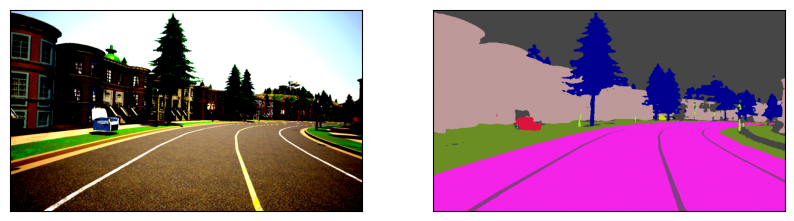

In [16]:
for batch in test_dl:

    imgs = batch['image'].to(device)
    labels = batch['labels'].to(device)
                
    logits = feature_extractor(imgs)
    probability_vector = get_probability(logits)

    fig, axs = plt.subplots(1, 2, figsize=(10, 12))
    idx = 2
    visualize_scene(imgs.cpu()[2], axs[0])
    visualize_annotation(torch.argmax(probability_vector,axis=3).cpu().detach().numpy()[2], axs[1])
    
    break
    
    